In [ ]:
import zipfile
import os

# Extract frames.zip
with zipfile.ZipFile('/content/frames.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/frames')

# Extract lane-masks.zip
with zipfile.ZipFile('/content/lane-masks.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/lane-masks')

# Verify extraction
print("Frames directory contents:", os.listdir('/content/frames')[:5])
print("Lane-masks directory contents:", os.listdir('/content/lane-masks')[:5])

Frames directory contents: ['frames']
Lane-masks directory contents: ['lane-masks']


In [ ]:
import os

# Check contents of the extracted folders
print("Frames subdirectory contents:", os.listdir('/content/frames'))
print("Lane-masks subdirectory contents:", os.listdir('/content/lane-masks'))


Frames subdirectory contents: ['frames']
Lane-masks subdirectory contents: ['lane-masks']


In [ ]:
image_dir = '/content/frames/frames'
mask_dir = '/content/lane-masks/lane-masks'


In [ ]:
print("Actual frames contents:", os.listdir(image_dir)[:5])
print("Actual lane-masks contents:", os.listdir(mask_dir)[:5])


Actual frames contents: ['0313-2_29400.jpg', '0313-2_975.jpg', '0313-1_7240.jpg', '0531_1492638387249489975.jpg', '0313-1_10760.jpg']
Actual lane-masks contents: ['0313-2_29400.jpg', '0313-2_975.jpg', '0313-1_7240.jpg', '0531_1492638387249489975.jpg', '0313-1_10760.jpg']


In [ ]:
images, masks = load_data(image_dir, mask_dir)


In [ ]:
# Load dataset
images, masks = load_data(image_dir, mask_dir)

# Split into training and validation sets
from sklearn.model_selection import train_test_split
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# Print dataset shapes for verification
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Masks Shape: {train_masks.shape}")
print(f"Validation Images Shape: {val_images.shape}")
print(f"Validation Masks Shape: {val_masks.shape}")


Train Images Shape: (2900, 256, 256, 3)
Train Masks Shape: (2900, 256, 256, 1)
Validation Images Shape: (726, 256, 256, 3)
Validation Masks Shape: (726, 256, 256, 1)


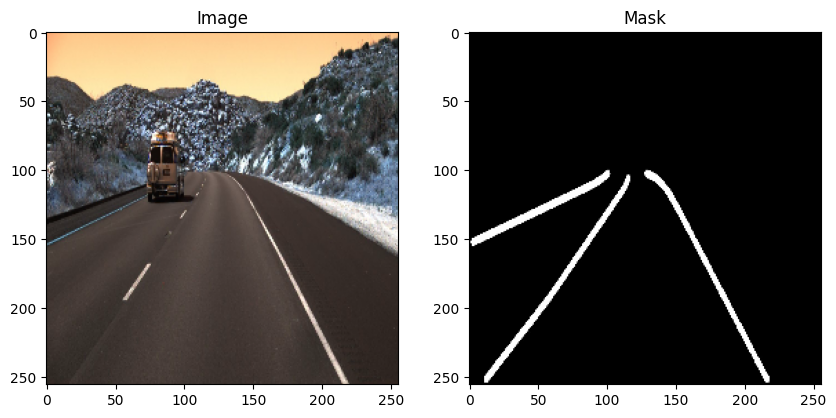

In [ ]:
import matplotlib.pyplot as plt

# Visualize a sample image and its mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(train_images[0])  # Display the first training image
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(train_masks[0].squeeze(), cmap='gray')  # Display the corresponding mask
plt.show()


In [ ]:
from tensorflow.keras import layers, Model
import tensorflow as tf

def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    return Model(inputs, outputs)

# Define and compile the model
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = unet_model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    batch_size=16, epochs=10
)


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.9448 - loss: 0.2159 - val_accuracy: 0.9440 - val_loss: 0.1443
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9462 - loss: 0.1300 - val_accuracy: 0.9503 - val_loss: 0.0938
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9531 - loss: 0.0859 - val_accuracy: 0.9532 - val_loss: 0.0812
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9561 - loss: 0.0727 - val_accuracy: 0.9568 - val_loss: 0.0672
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9576 - loss: 0.0665 - val_accuracy: 0.9577 - val_loss: 0.0637
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9589 - loss: 0.0606 - val_accuracy: 0.9581 - val_loss: 0.0633
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9597 - loss: 0.0576 - val_accuracy: 0.9590 - val_loss: 0.0588
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9598 - loss: 0.0566 -

In [ ]:
val_loss, val_accuracy = unet_model.evaluate(val_images, val_masks)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.9597 - loss: 0.0549
Validation Loss: 0.05535556748509407
Validation Accuracy: 0.9598420858383179


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


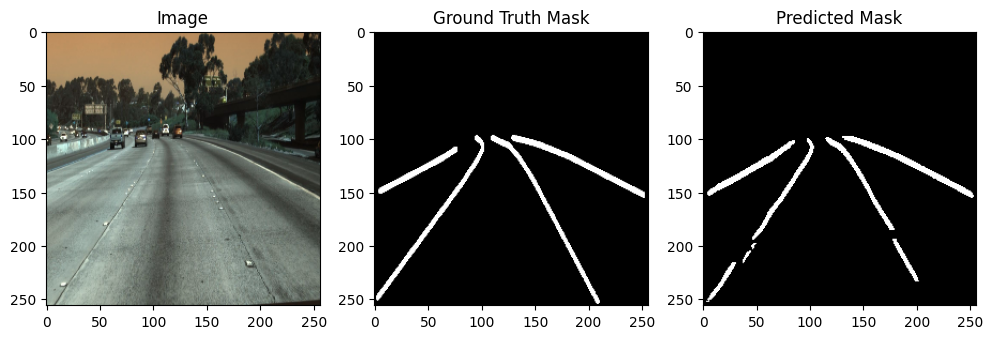

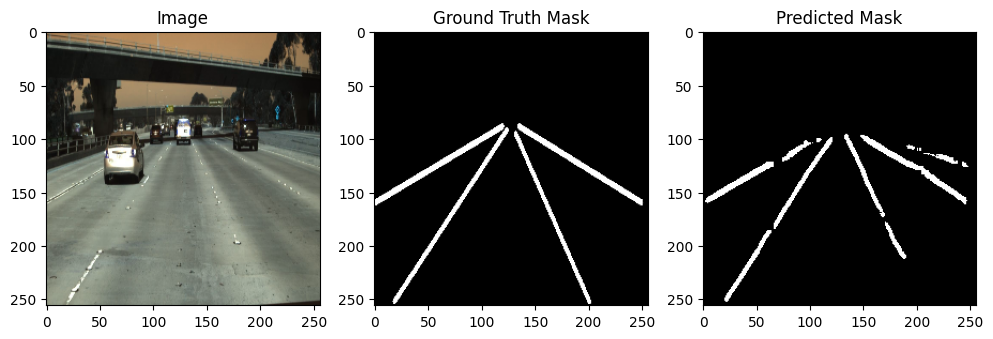

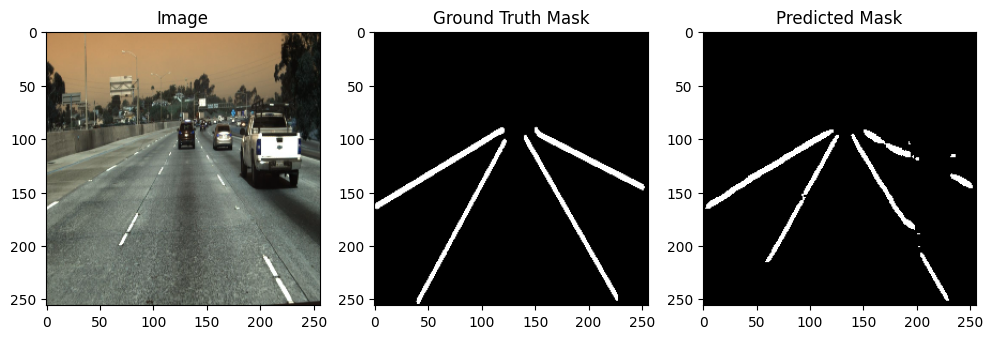

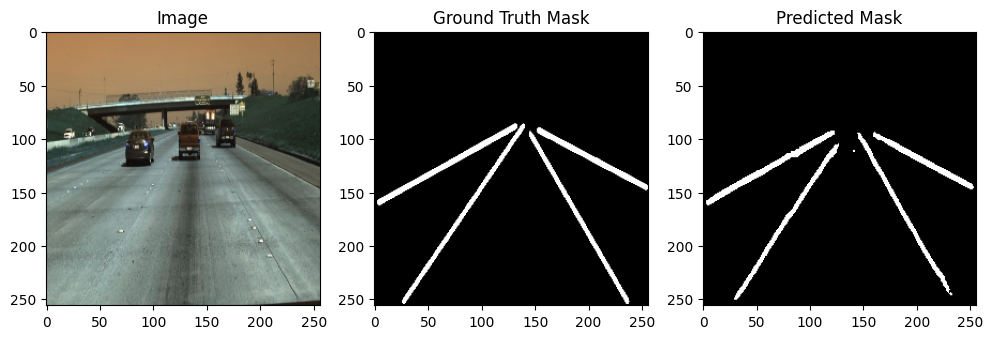

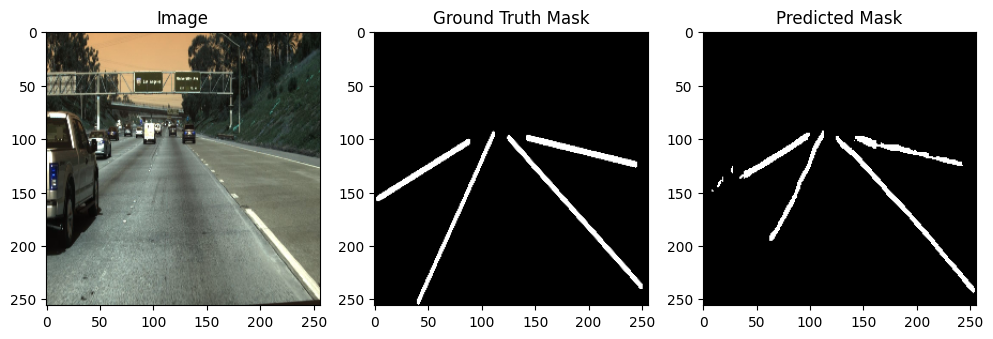

In [ ]:
# Visualize predictions
preds = unet_model.predict(val_images[:5])  # Predict for the first 5 validation images
preds = (preds > 0.5).astype(np.uint8)  # Apply threshold to binarize predictions

import matplotlib.pyplot as plt
for i in range(5):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(val_images[i])

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(val_masks[i].squeeze(), cmap='gray')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(preds[i].squeeze(), cmap='gray')

    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

def build_deeplabv3_fixed(input_shape=(256, 256, 3)):
    """
    Build DeepLabV3+ with sufficient upsampling layers to match target shape (256x256x1).
    """
    # Backbone: Pretrained MobileNetV2
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")
    base_model.trainable = False  # Freeze the backbone

    # Get the feature maps from the last convolutional layer
    x = base_model.output  # Output shape will be something like (None, 8, 8, 1280)

    # Add intermediate Conv2D layers to refine feature maps
    x = layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)

    # Upsample in multiple steps to reach 256x256 resolution
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)  # 16x16
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)  # 32x32
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)  # 64x64
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)  # 128x128
    x = layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding="same", activation="sigmoid")(x)  # 256x256

    return models.Model(inputs=base_model.input, outputs=x)

# Build and compile the updated model
deeplabv3_model = build_deeplabv3_fixed()
deeplabv3_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
deeplabv3_model.summary()

# Verify output shape
print(f"Updated Model Output Shape: {deeplabv3_model.output_shape}")


<ipython-input-51-18c0354da290>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 128, 128, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 128, 128, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 128, 128, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 128, 128, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 129, 129, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 64, 64, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 9,724,225 (37.09 MB)

 Trainable params: 7,466,241 (28.48 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Updated Model Output Shape: (None, 256, 256, 1)


In [ ]:
history = deeplabv3_model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    batch_size=16,
    epochs=10
)


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.9095 - loss: 0.2244 - val_accuracy: 0.9440 - val_loss: 0.1129
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9451 - loss: 0.1032 - val_accuracy: 0.9455 - val_loss: 0.1002
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9481 - loss: 0.0844 - val_accuracy: 0.9464 - val_loss: 0.0957
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9516 - loss: 0.0713 - val_accuracy: 0.9462 - val_loss: 0.0964
Epoch 5/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9555 - loss: 0.0606 - val_accuracy: 0.9462 - val_loss: 0.0976
Epoch 6/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9579 - loss: 0.0542 - val_accuracy: 0.9455 - val_loss: 0.1103
Epoch 7/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9600 - loss: 0.0489 - val_accuracy: 0.9458 - val_loss: 0.1115
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9616 - loss: 0.0444 - val_acc

In [ ]:
val_loss, val_accuracy = deeplabv3_model.evaluate(val_images, val_masks)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.9447 - loss: 0.1277
Validation Loss: 0.1273898482322693
Validation Accuracy: 0.9450269341468811


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


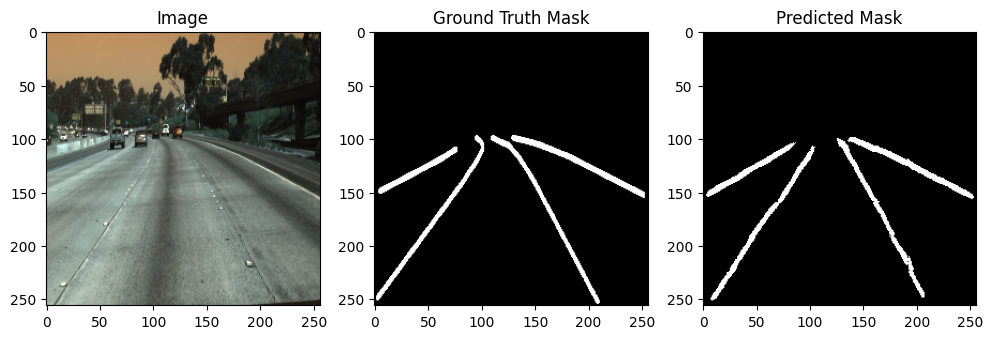

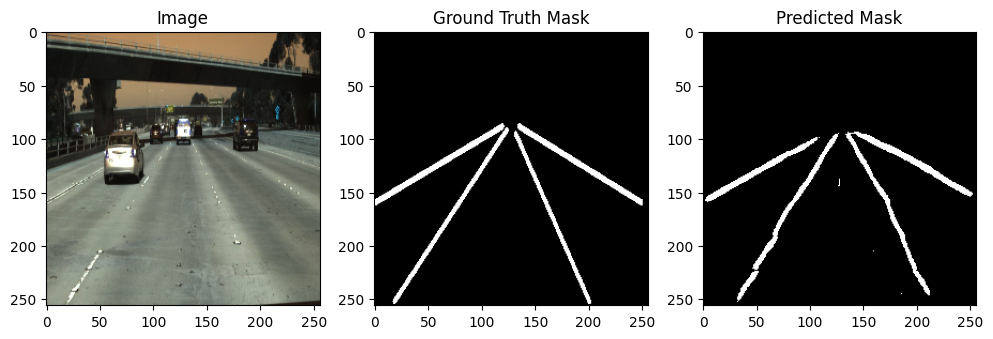

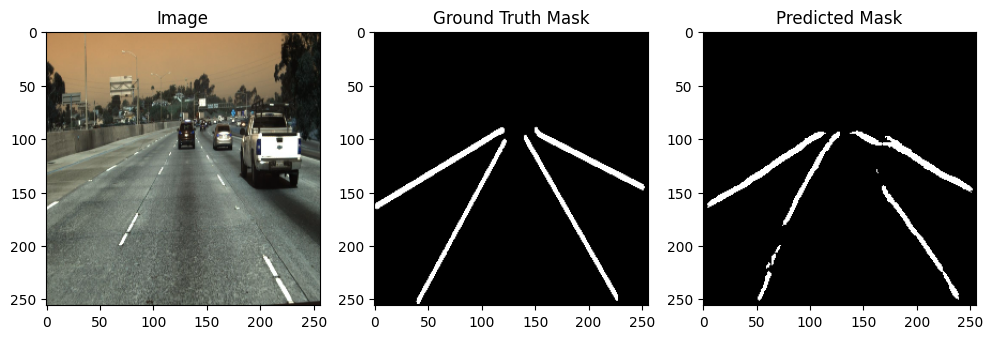

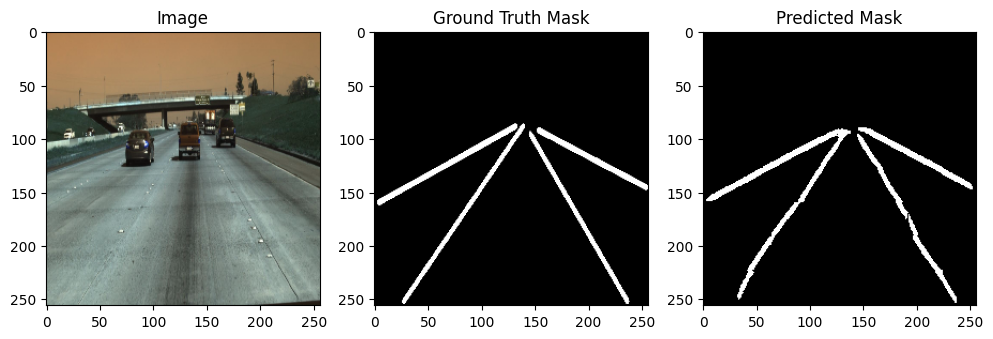

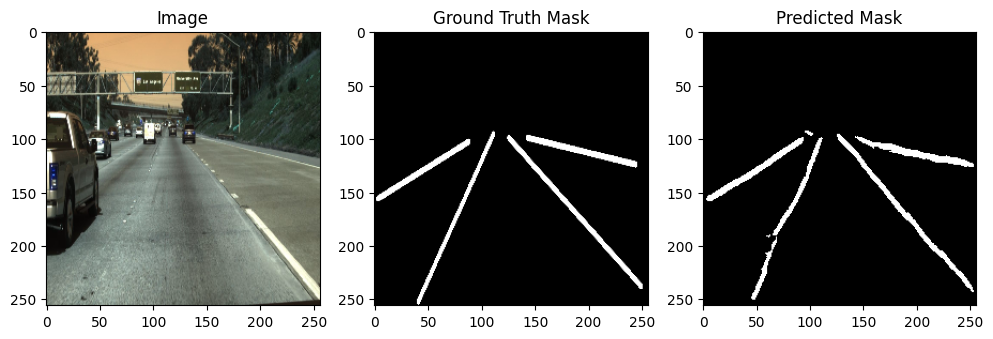

In [ ]:
import matplotlib.pyplot as plt

# Predict on validation images
preds = deeplabv3_model.predict(val_images[:5])
preds = (preds > 0.5).astype(int)  # Binarize predictions

# Plot the results
for i in range(5):
    plt.figure(figsize=(12, 4))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(val_images[i])

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(val_masks[i].squeeze(), cmap='gray')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(preds[i].squeeze(), cmap='gray')

    plt.show()
